# CSCA-5642, CNN Cancer Detection

# Brief description of the problem and data


In this notebook I'm training different CNNs to find the best model detecting metastatic cancer in small image patches provided by PatchCamelyon (PCam) and preprocessed by Kaggle.

## Dataset
Dataset consist of two parts: the labeled one used for model training and validation, and the unlabeled for prediction, for participating in the competition. All the files in both parts are 96x96 RGB tiff images

* train: 220025 files, 5.72 GB
* test: 57458 files, 1.49 GB

Labels are given as a `train_labels.csv` file with two columns: `id` (file name without extension) and `label` - binary, 0 or 1. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.


At Kaggle the dataset and working directory are mounted to this paths:

In [1]:
DATASET_DIR = '/kaggle/input/histopathologic-cancer-detection/'
WORKING_DIR = '/kaggle/working/'

# Exploratory Data Analysis (EDA)

To get a brief overview let's take a look at the csv files, and a few images

In [2]:
from os import path
import pandas as pd

df = pd.read_csv(path.join(DATASET_DIR, 'train_labels.csv'))
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


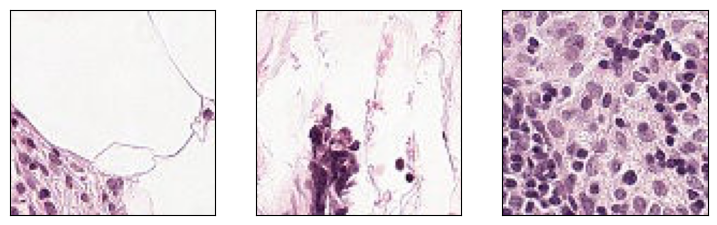

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(9,3))
for i in range(3):
    filename = f'{df.iloc[i]["id"]}.tif'
    filepath = path.join(DATASET_DIR, 'train', filename)
    img = plt.imread(filepath)
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

## Label distribution
The labels are not evenly distributed, there are more negative than positive samples. The ratio is appproximately 60/40:

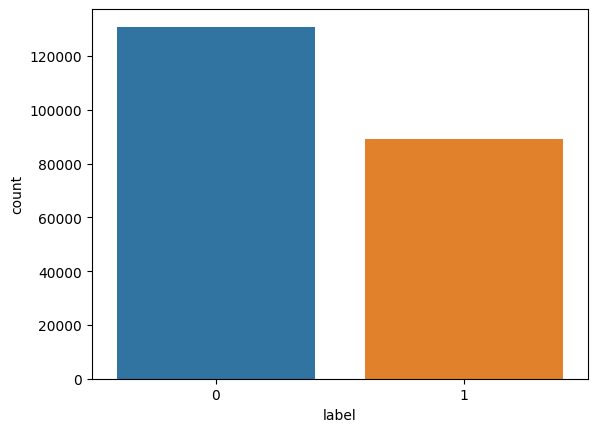

label==0: 130908
label==1: 89117


In [4]:
import seaborn as sns
sns.countplot(x='label', data=df)
plt.show()

print('label==0:', df[df['label']==0].shape[0])
print('label==1:', df[df['label']==1].shape[0])

## Low contrast images

Although the most of the images are good and sharp, there are multiple not very good, very low contrast. From a human standpoint they mish be considered "corrupted" and don't bring much value, but they can still be used for training just becasue the robust model should perform OK on the corrupded images too. Here are some from the "training" subset, there are many like these in the "tests" subset too. I considered retaining them since there is no easy formula to identify *outlierness*.

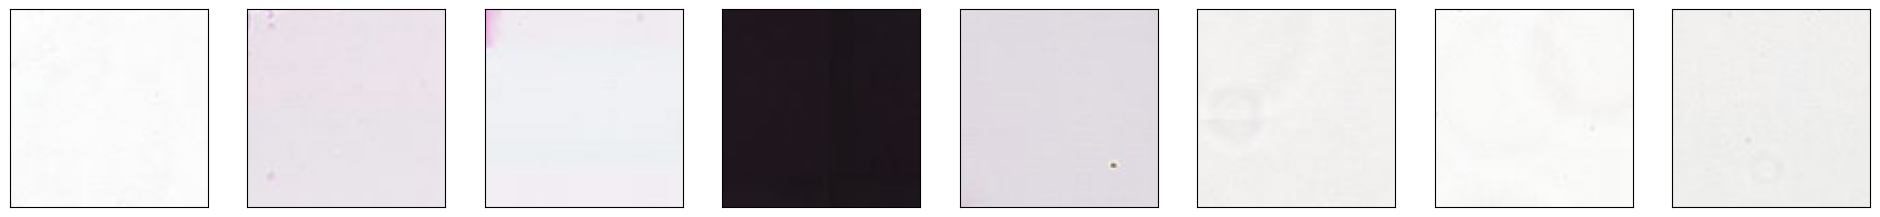

In [24]:
bad = [
    '0b2f343898d4024405b49ba444557805347c847a',
    'c3b79e987d08f06dd0d50aa18795dc8e37b755d8',
    'd321cbdeed2fcaa4adb3a2eeda922f09b6e62e0d',
    '38d5d6c3ff5cb0d04fc1db4cb23fd16f741fc2e7',
    '8238f435dbc15f5ee93aa4c4645d0e609d8c8a7f',
    '7f88140c49153bc3a7fb9329c64e1b50831c1e73',
    'a3a379c46de812f44a7e70c5018e924371f7c4f6',
    'e6e2c102bc7a78ecb7630d7281a0e169bd581572',
]

fig, ax = plt.subplots(1,len(bad),figsize=(3*len(bad),3))
for i in range(len(bad)):
    filename = f'{bad[i]}.tif'
    filepath = path.join(DATASET_DIR, 'train', filename)
    img = plt.imread(filepath)
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()


## Data preprocessing

Keras TensorFlow has a few ways to feed images into the model being trained or evaluated. The most convenient of them looks to be `tf.keras.preprocessing.image_dataset_from_directory`, but unfortunately for some reason it doesn't support tiff images. An alternative way would be to foloow a genteric way `tf.data.Dataset.from_tensor_slices` and dynamically follow the way: Dataset.map -> tf.numpy_function -> PIL.Image.open and load tiff images on the fly, but I found it extremely slow. I eventually leaned towards converting the dataset into one of the supported image formats and utilizing the fast `image_dataset_from_directory` approach, but there was a caveat: which format image to choose? Tiff wouldn't work:
~~~
ValueError: No images found in directory /kaggle/input/histopathologic-cancer-detection-working/test. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
~~~

## Why not jpeg

After training a simple model with `from_tensor_slices` I migrated to `image_dataset_from_directory` to evolve the rest from there. I converted the test dataset to jpegs, re-ran the test, re-uploaded the submission to Kaggle and observed a noticeble drop in numbers. After manually expecting the samples I found this problem, let me plot it:

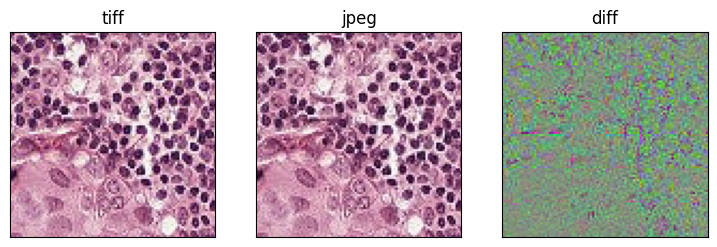

In [6]:
import io
from PIL import Image
import numpy as np

buf = io.BytesIO()
tif = Image.open(path.join(DATASET_DIR, 'test', '725dabe6ecccc68b958a2c7dd75bcbf362c7cb03.tif'))
tif.save(buf, format='JPEG', quality=95)
buf.seek(0)

jpg = Image.open(buf)

fig, axes = plt.subplots(1,3,figsize=(9,3))

axes[0].imshow(tif)
axes[1].imshow(jpg)

diff = np.array(jpg, dtype=np.float32) - np.array(tif, dtype=np.float32)
diff = (diff - diff.min(axis=(0,1))) / (diff.max(axis=(0,1)) - diff.min(axis=(0,1)))
axes[2].imshow(diff)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])


axes[0].set_title('tiff')
axes[1].set_title('jpeg')
axes[2].set_title('diff')

plt.show()

Jpeg format introduces quite a bit of hidden regularities, they seem to affect the prediction quality, eventually I decided to just convert everything to bmp.

## Center 32x32 patch


The dataset description says: *A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.*. This looked promising to carve the 32x32 out of the test images and only focus of this small patch, but comparing to the original 96x96 the quality didn't improve. I tried multiple appproaches:

1. Crop the 32x32 center, drop the rest
2. Pad everything around the patch with the mean color
3. Tile 96x96 with 32x32 patches.

In [30]:
IMG_SIZE = 96
TILE_SIZE = 32

def zoom_cetner_pacth(img):    
    result = img.crop((TILE_SIZE, TILE_SIZE, 2*TILE_SIZE, 2*TILE_SIZE))
    result = result.resize((IMG_SIZE, IMG_SIZE))
    return result

def keep_center_patch_pad_rest(img):
    arr = np.array(img)
    center_patch = arr[TILE_SIZE:2*TILE_SIZE, TILE_SIZE:2*TILE_SIZE, :]
    mean_color = center_patch.mean(axis=(0,1)).astype(np.uint8)
    result = np.ones_like(arr, dtype=np.uint8) * mean_color
    result[TILE_SIZE:2*TILE_SIZE, TILE_SIZE:2*TILE_SIZE, :] = center_patch
    return Image.fromarray(result)

def tile_with_cetner_patch(img):
    arr = np.array(img)
    center_patch = arr[TILE_SIZE:2*TILE_SIZE, TILE_SIZE:2*TILE_SIZE, :]
    result = np.tile(center_patch, (3, 3, 1))
    return Image.fromarray(result)

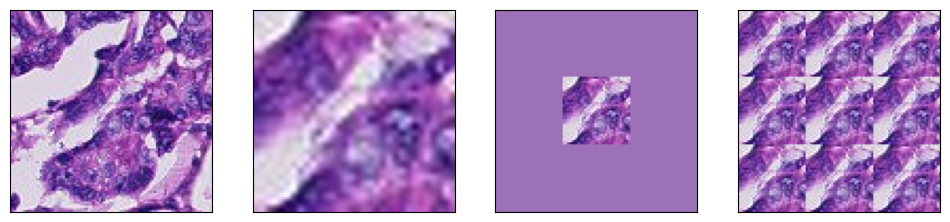

In [20]:
tif = Image.open(path.join(DATASET_DIR, 'test', '0000ec92553fda4ce39889f9226ace43cae3364e.tif'))

fig, axes = plt.subplots(1,4,figsize=(12,3))

axes[0].imshow(tif)
axes[1].imshow(zoom_cetner_pacth(tif))
axes[2].imshow(keep_center_patch_pad_rest(tif))
axes[3].imshow(tile_with_cetner_patch(tif))

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

But nothing actually worked. I uploaded all the results to the competition and all the alternative approaches gave worse scores. So I decided to stay with 96x96 with no other preprocessing than just converting to BMP. **TODO**: tell, that the context probably matters

In [21]:
from concurrent.futures import ThreadPoolExecutor

MAX_WORKERS = 16

def copy_chunk_tiff_jpeg(file_ids, dir_from, dir_to, transform):
    for id in file_ids:
        path_from = path.join(dir_from, f'{id}.tif')
        path_to = path.join(dir_to, f'{id}.bmp')
        img = Image.open(path_from)
        img = img.convert('RGB')

        if transform:
            img = transform(img)

        img.save(path_to, format='BMP')

def copy_tiff_jpeg(file_ids, dir_from, dir_to, transform=None):
    chunks = [file_ids.iloc[i::MAX_WORKERS] for i in range(MAX_WORKERS)]
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(lambda chunk: copy_chunk_tiff_jpeg(chunk, dir_from, dir_to, transform), chunks)

In [22]:
dataset_train = path.join(DATASET_DIR, 'train')
dataset_test = path.join(DATASET_DIR, 'test')

working_train = path.join(WORKING_DIR, 'train')
working_test = path.join(WORKING_DIR, 'test')

In [37]:
from os import makedirs

# Convert the training samples to jpegs
if not path.exists(working_train):
    working_train_0 = path.join(working_train, '0')
    working_train_1 = path.join(working_train, '1')
    
    makedirs(working_train_0, exist_ok=True)
    makedirs(working_train_1, exist_ok=True)
    
    df = pd.read_csv(path.join(DATASET_DIR, 'train_labels.csv'))
    train_ids0 = df[df['label'] == 0]['id']
    train_ids1 = df[df['label'] == 1]['id']
    
    copy_tiff_jpeg(train_ids0, dataset_train, working_train_0)
    copy_tiff_jpeg(train_ids1, dataset_train, working_train_1)


# And the test samples as well
if not path.exists(working_test):
    makedirs(working_test, exist_ok=True)
    df = pd.read_csv(path.join(DATASET_DIR, 'sample_submission.csv'))
    test_ids = df['id']
    
    copy_tiff_jpeg(test_ids, dataset_test, working_test)

# Model Architecture


Since it's an image classification, image structure recognition task, it's reasonable to try CNN. But the actual CNN details are not obvious to guess with a quick glance. I just trained a few models with different characteristics and ran the training algorithms to compare the metrics. There was no particular logic to follow, I only wanted the models to be small enough and fast to train. I also wanted the majority of training parameters to be concentrated at convolutional layers, not at the dense layer. So there are the models I tried:

1. Some baseline model
2. Almost the same, but strides=2 instead of max-pooling
3. While experimenting I discovered that the previous model overfits fast. here I just added some disturbance: RandomFlip, RandomRotation
4. Generalizing with BatchNormalization, small dense layer
5. The same as above, but relu activation *after* normalization, so it first shifts to mean values before trimming the negative range. Also a little bigger dense layer




In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Rescaling, RandomFlip, Activation, RandomRotation
from tensorflow.keras import Input

def make_baseline_model():
    return Sequential(name='baseline', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_strided_model():
    return Sequential(name='strided', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_disturbed_model():
    return Sequential(name='disturbed', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        RandomFlip(),
        RandomRotation(factor=(-0.1, 0.1)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_normalized_model():
    return Sequential(name='normalized', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def make_tweaked_model():
    return Sequential(name='tweaked', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),        
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3, 3)),
        Activation('relu'),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

Tell about f1_score, auc

In [45]:
import json
import tensorflow as tf

def run_training(model, results_dir, epochs=20, save_best_only=True):
    model_file_path = path.join(results_dir, model.name + '_epoch_{epoch:02d}_val_loss_{val_loss:.3f}.keras')
    history_file_path = path.join(results_dir, model.name + '_history.json')

    if path.exists(history_file_path):
        print(f'Training of the model {model.name} has already completed. If want to retrain with different settings, please manually delete the artifact: {history_file_path}')
        return
        
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['binary_accuracy', 'auc', 'f1_score'])

    checkpoint_cb = ModelCheckpoint(
        monitor='val_auc',
        mode='max',
        filepath=model_file_path,
        save_best_only=save_best_only,
        save_freq='epoch'
    )

    print(f'About to start training the model {model.name}')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint_cb]
    )
    
    with open(history_file_path, 'w') as f:
        json.dump(history.history, f, indent=4)


def run_training_all(models, results_dir):
    makedirs(results_dir, exist_ok=True)
    for model in models:
        tf.keras.backend.clear_session()
        run_training(model, results_dir)

Tell about bach_size, tell about metrics, about not stratified. Tell about the idea to track auc instead of loss of f1_score


In [ ]:
train_ds, val_ds = image_dataset_from_directory(
    working_train,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    validation_split=0.1,
    shuffle=True,
    subset='both',
    seed=2025)

In [44]:
models = [
    make_baseline_model(),
    make_strided_model(),
    make_disturbed_model(),
    make_normalized_model(),
    make_tweaked_model()
]

results_dir = path.join(WORKING_DIR, 'BATCH512_SEED2025')
run_training_all(models, results_dir)

Training of the model baseline has already completed. If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED2025/baseline_history.json
Training of the model strided has already completed. If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED2025/strided_history.json
Training of the model disturbed has already completed. If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED2025/disturbed_history.json
Training of the model normalized has already completed. If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED2025/normalized_history.json
Training of the model tweaked has already completed. If want to retrain with different settings, please manually delete the artifact: /kaggle/working/BATCH512_SEED2025/tweaked_history.json


# Results and Analysis

In [65]:
stats = dict()
model_names = [model.name for model in models]
for model_name in model_names:
    history_path = path.join(results_dir, f'{model_name}_history.json')
    with open(history_path, 'r') as f:
        stats[model_name] = json.load(f)

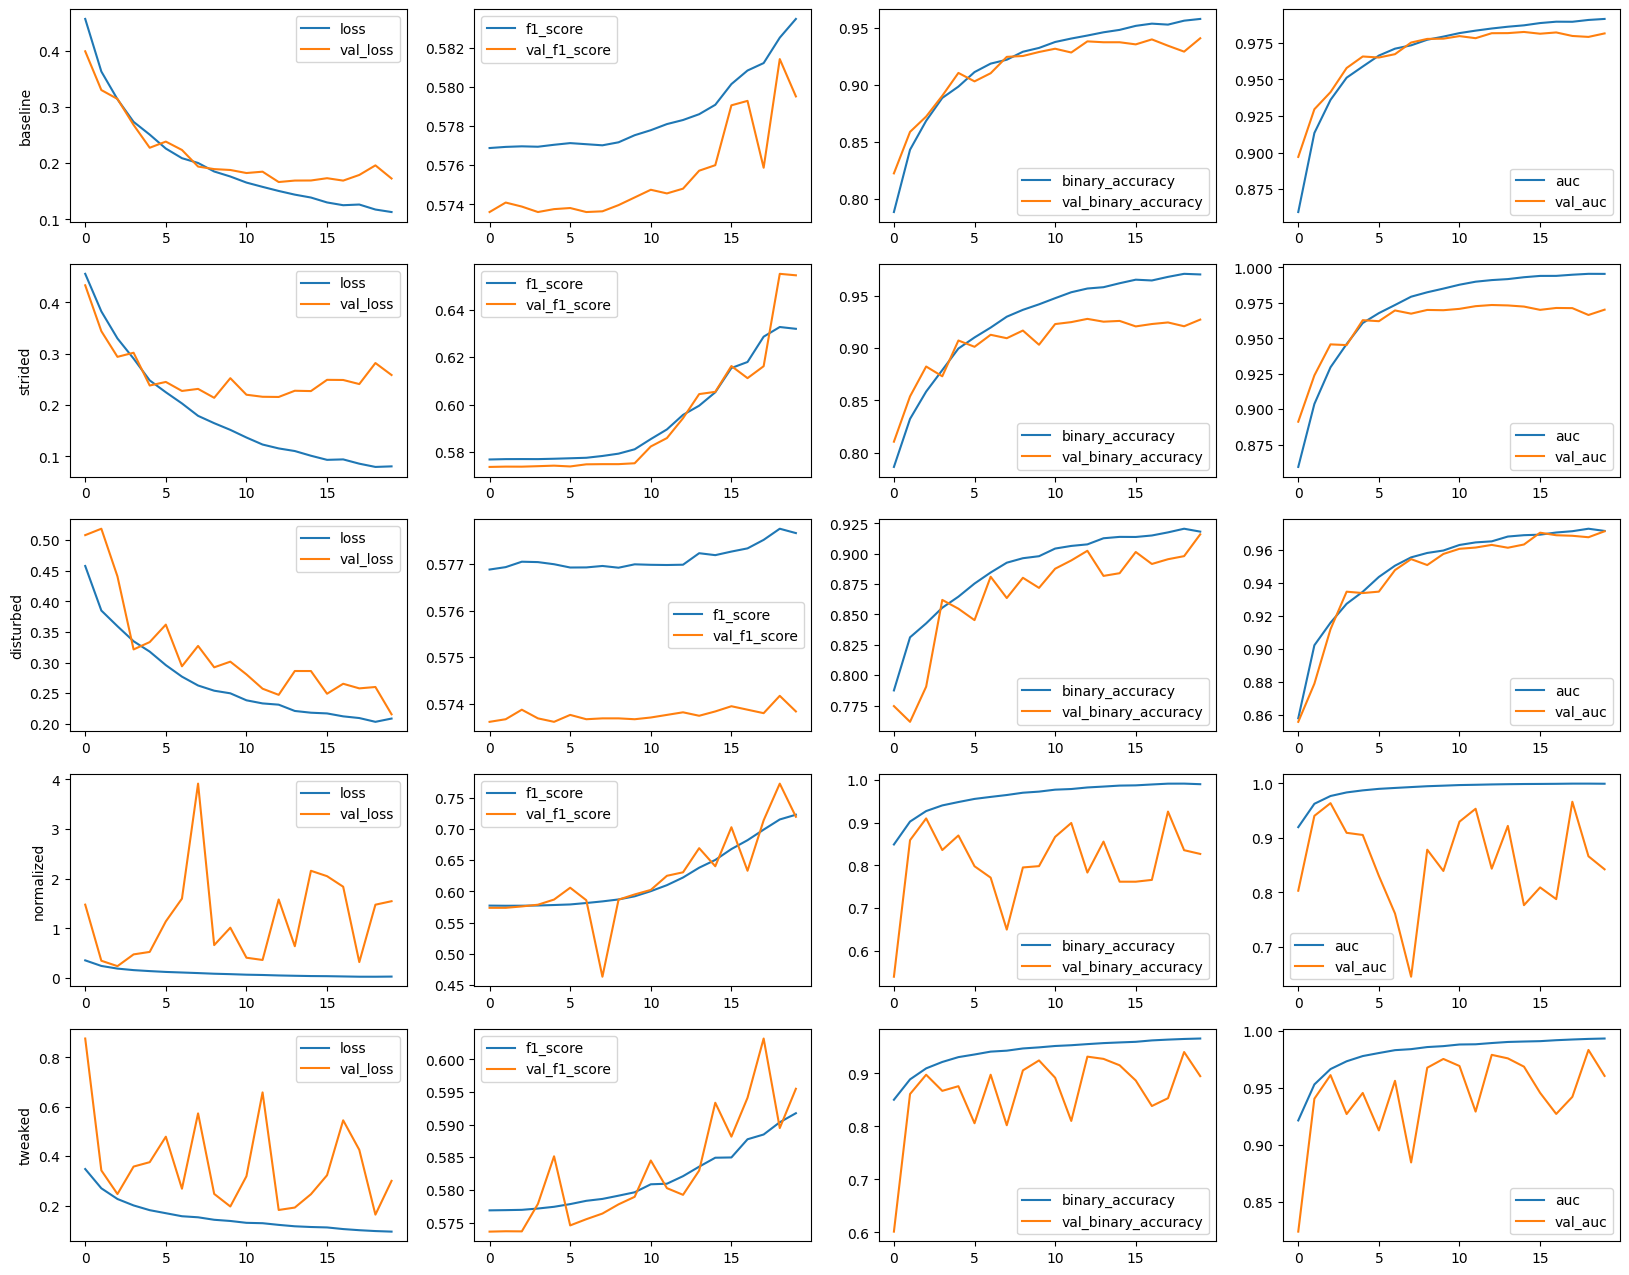

In [74]:
metrics = ['loss','f1_score','binary_accuracy','auc']

n = len(model_names)
m = len(metrics)

fig, axes = plt.subplots(n,m,figsize=(n*4,m*4))

for i,model_name in enumerate(model_names):
    for j,metric in enumerate(metrics):
        axes[i][0].set_ylabel(model_name)
        axes[i][j].plot(stats[model_name][metric], label=metric)
        axes[i][j].plot(stats[model_name]['val_'+metric], label='val_'+metric)
        axes[i][j].legend()
        

plt.show()

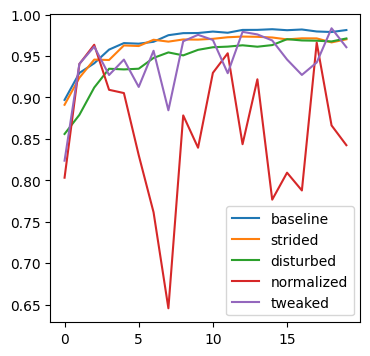

In [78]:
fig, axes = plt.subplots(1,1,figsize=(4,4))

for model_name in model_names:
    plt.plot(stats[model_name]['val_auc'], label=model_name)
    plt.legend()

plt.show()

## Submission


Tell something 

In [ ]:
test_ds = image_dataset_from_directory(
    working_test,
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=False)

test_ids = [p[-44:-4] for p in test_ds.file_paths]
df = pd.DataFrame({'id': test_ids})

In [87]:
from os import listdir

all_files_sorted = sorted(listdir(results_dir))

for model_name in model_names:
    best_model_file = [f for f in all_files_sorted if f.startswith(model_name) and f.endswith('.keras')][-1]
    best_model_path = path.join(results_dir, best_model_file)
    model = tf.keras.models.load_model(best_model_path)

    df['label'] = model.predict(test_ds)

    best_model_file_no_ext, _ = path.splitext(best_model_file)
    submission_file_path = path.join(results_dir, f'{best_model_file_no_ext}.csv')
    df.to_csv(submission_file_path, index=False)

    print('Saved results to: ', submission_file_path)

baseline
strided
disturbed
normalized
tweaked


TODO: table compare results

# Conclusion

Tell that next is transfer

1. knowledge transfer
2. play with different number of layers, and number of activators






# =====================================================================================

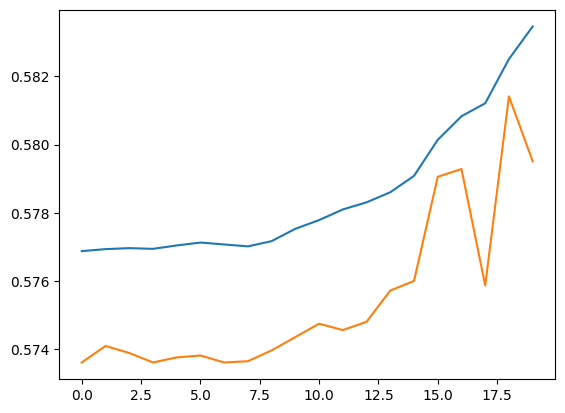

In [55]:
plt.plot(stats['baseline']['f1_score'])
plt.plot(stats['baseline']['val_f1_score'])
plt.show()

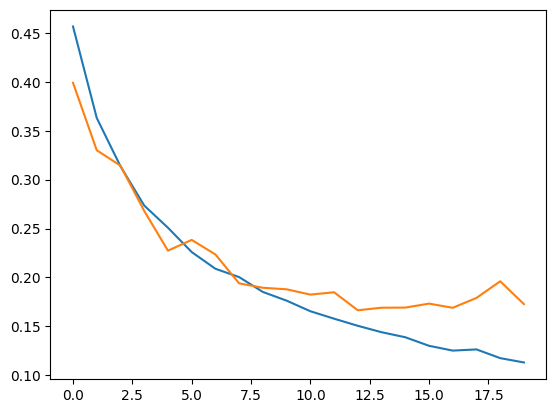

In [56]:
plt.plot(stats['baseline']['loss'])
plt.plot(stats['baseline']['val_loss'])
plt.show()

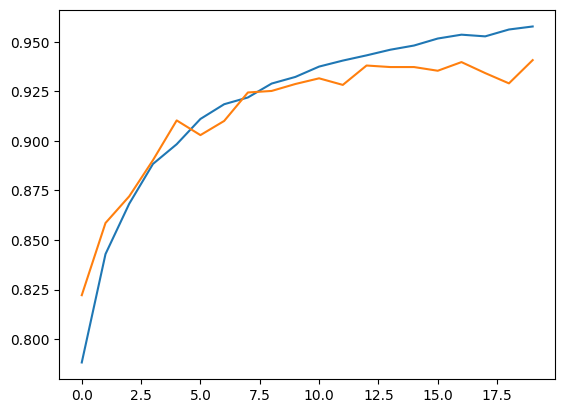

In [58]:
plt.plot(stats['baseline']['binary_accuracy'])
plt.plot(stats['baseline']['val_binary_accuracy'])
plt.show()

# ========================================================================

# Results and Analysis

In [ ]:
import os
from os import path
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
import json


DATASET_DIR = '/kaggle/input/histopathologic-cancer-detection/'
WORKING_DIR = '/kaggle/working/'
BATCH_SIZE = 512
IMG_SIZE = 96

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
MAX_WORKERS = 16

def copy_chunk_tiff_jpeg(file_ids, dir_from, dir_to):
    for id in file_ids:
        path_from = path.join(dir_from, f'{id}.tif')
        path_to = path.join(dir_to, f'{id}.bmp')
        img = Image.open(path_from)
        img = img.convert('RGB')
        img.save(path_to)

def copy_tiff_jpeg(file_ids, dir_from, dir_to):
    chunks = [file_ids.iloc[i::MAX_WORKERS] for i in range(MAX_WORKERS)]
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(lambda chunk: copy_chunk_tiff_jpeg(chunk, dir_from, dir_to), chunks)

In [ ]:
dataset_train = path.join(DATASET_DIR, 'train')
dataset_test = path.join(DATASET_DIR, 'test')

working_train = path.join(WORKING_DIR, 'train')
working_test = path.join(WORKING_DIR, 'test')

~~~
ValueError: No images found in directory /kaggle/input/histopathologic-cancer-detection-working/test. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')
~~~

Converting 200k+ tiffs to bmps will take a while, about 10 minutes, the output size should grow to 7.5 GiB

In [ ]:
# Convert the training samples to jpegs
if not path.exists(working_train):
    working_train_0 = path.join(working_train, '0')
    working_train_1 = path.join(working_train, '1')
    
    makedirs(working_train_0, exist_ok=True)
    makedirs(working_train_1, exist_ok=True)
    
    df = pd.read_csv(path.join(DATASET_DIR, 'train_labels.csv'))
    train_ids0 = df[df['label'] == 0]['id']
    train_ids1 = df[df['label'] == 1]['id']
    
    copy_tiff_jpeg(train_ids0, dataset_train, working_train_0)
    copy_tiff_jpeg(train_ids1, dataset_train, working_train_1)


# And the test samples as well
if not path.exists(working_test):
    makedirs(working_test, exist_ok=True)
    df = pd.read_csv(path.join(DATASET_DIR, 'sample_submission.csv'))
    test_ids = df['id']
    
    copy_tiff_jpeg(test_ids, dataset_test, working_test)

Not stratified

In [ ]:
train_ds, val_ds = image_dataset_from_directory(
    working_train,
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    validation_split=0.1,
    shuffle=True,
    subset='both',
    seed=2025)

In [ ]:
def run_training(model, results_dir, epochs=20, save_best_only=True):
    model_file_path = path.join(results_dir, model.name + '_epoch_{epoch:02d}_val_loss_{val_loss:.3f}.keras')
    history_file_path = path.join(results_dir, model.name + '_history.json')

    if path.exists(history_file_path):
        print(f'Training of the model {model.name} has already completed. If want to retrain with different settings, please manually delete the artifact: {history_file_path}')
        return
        
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['binary_accuracy', 'auc', 'f1_score'])

    checkpoint_cb = ModelCheckpoint(
        monitor='val_auc',
        mode='max',
        filepath=model_file_path,
        save_best_only=save_best_only,
        save_freq='epoch'
    )

    print(f'About to start training the model {model.name}')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint_cb]
    )
    
    with open(history_file_path, 'w') as f:
        json.dump(history.history, f, indent=4)


def run_training_all(models, results_dir):
    makedirs(results_dir, exist_ok=True)
    for model in models:
        tf.keras.backend.clear_session()
        run_training(model, results_dir)

In [ ]:
def make_baseline_model():
    return Sequential(name='baseline', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_strided_model():
    return Sequential(name='strided', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_disturbed_model():
    return Sequential(name='disturbed', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        RandomFlip(),
        RandomRotation(factor=(-0.1, 0.1)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_normalized_model():
    return Sequential(name='normalized', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

def make_tweaked_model():
    return Sequential(name='tweaked', layers=[
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),        
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(256, (3, 3)),
        Activation('relu'),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


# TRAINING

In [ ]:
models = [
    make_baseline_model(),
    make_strided_model(),
    make_disturbed_model(),
    make_normalized_model(),
    make_tweaked_model()
]

In [ ]:
results_dir = path.join(WORKING_DIR, 'BATCH512_SEED2025')
run_training_all(models, results_dir)

In [ ]:
#!rm -rf BATCH512_SEED2025

#!ls BATCH512_SEED2025
!zip -q training_results_10301332.zip BATCH512_SEED2025/*

In [ ]:
#!mv BATCH128_SEED0043 BATCH128_SEED0042
#!mv *epoch*.keras BATCH128_SEED0042
#!mv *history*.json BATCH128_SEED0042

#!ls -l

#!ls *epoch*.keras

In [ ]:
#!ls *.json *.keras
#!zip training_results_10271314.zip *.json *.keras

#!rm *.json *.keras *.zip

!rm *.zip

# TESTING

In [ ]:
test_ds = image_dataset_from_directory(
    working_test,
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=False)

# REMAINDER

In [ ]:
def make_baseline_model():
    return Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

In [ ]:
def make_checkpoint_cb(model_name, template, save_best_only):
    filepath = path.join(WORKING_DIR, 'checkpoints', model_name, template)
    return ModelCheckpoint(
        filepath=filepath,
        save_freq='epoch',
        save_best_only=save_best_only)

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    baseline_model = make_baseline_model()
    baseline_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', 'auc'])


In [ ]:
filepath = path.join(WORKING_DIR, 'baseline_epoch_{epoch:02d}_accuracy_{val_accuracy:.3f}.keras')
checkpoint_cb = ModelCheckpoint(
    filepath=filepath,
    save_freq='epoch'
)

#history_baseline = baseline_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=15,
#    callbacks=[checkpoint_cb]
#)

In [ ]:
def make_advanced_model_old():
    return Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        RandomFlip(),
        Conv2D(32, (3, 3), strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_advanced_model_old2():
    return Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        #RandomFlip(),
        Conv2D(32, (3, 3)),
        #BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3)),
        #BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3)),
        #BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3)),
        #BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

def make_advanced_model():
    return Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])


strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    advanced_model = make_advanced_model()
    advanced_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', 'auc'])

In [ ]:
filepath = path.join(WORKING_DIR, 'advanced_epoch_{epoch:02d}_accuracy_{val_accuracy:.3f}.keras')
checkpoint_cb = ModelCheckpoint(
    filepath=filepath,
    save_freq='epoch'
)

#history_advanced = advanced_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=15,
#    callbacks=[checkpoint_cb]
#)

In [ ]:
#!ls -l *.keras

In [ ]:
def make_disturbed_model():
    return Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        RandomFlip(),
        RandomRotation(factor=(-0.2, 0.2)),
        Conv2D(32, (3, 3), strides=2, activation='relu'),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    disturbed_model = make_advanced_model()
    disturbed_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', 'auc'])

In [ ]:
filepath = path.join(WORKING_DIR, 'disturbed_epoch_{epoch:02d}_accuracy_{val_accuracy:.3f}.keras')
checkpoint_cb = ModelCheckpoint(
    filepath=filepath,
    save_freq='epoch'
)

#history_disturbed = disturbed_model.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=15,
#    callbacks=[checkpoint_cb]
#)

In [ ]:
#import json

#with open('history_disturbed_epoch_all.json', 'w') as f:
#    json.dump(history.history, f, indent=4)


In [ ]:
#!ls *.zip

In [ ]:
#!ls *epoch*
#!zip -q training_histories.zip *epoch*

# NOW TRYING TO READ from_tensor_slices

In [ ]:
from sklearn.model_selection import train_test_split
#print(DATASET_DIR)

#!ls /kaggle/input/histopathologic-cancer-detection/


df = pd.read_csv(path.join(DATASET_DIR, 'train_labels.csv'))
X = df['id'].apply(lambda x: path.join(DATASET_DIR, 'train', f'{x}.tif')).values
y = df['label']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
def load_image(path, label):

    def read_image(p):
        img = Image.open(p.decode("utf-8")).convert("RGB")
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.array(img, dtype=np.uint8)
    
    image = tf.numpy_function(read_image, [path], tf.uint8)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = tf.cast(image, tf.float32) / 255.0
    return image, label


def load_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
train_ds = load_ds(X_train, y_train)
valid_ds = load_ds(X_valid, y_valid)

In [ ]:
for images, labels in train_ds.take(1):
    print(f"Normalized image batch shape: {images.shape}")
    print(f"Normalized image pixel value example: {images[0, 0, 0, 0]}")


In [ ]:
def make_baseline_model_once_again():
    return Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        Rescaling(1./255),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    baseline_model_once_again = make_baseline_model_once_again()
    baseline_model_once_again.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy', 'auc'])


In [ ]:
#filepath = path.join(WORKING_DIR, 'baseline_oa_epoch_{epoch:02d}_accuracy_{val_accuracy:.3f}.keras')
#checkpoint_cb = ModelCheckpoint(
#    filepath=filepath,
#    save_freq='epoch'
#)

#history_baseline_oa = baseline_model_once_again.fit(
#    train_ds,
#    validation_data=valid_ds,
#    epochs=1,
#    callbacks=[checkpoint_cb]
#)

#!mv ./train ./train-jpg
#!mv ./test ./test-jpg

#!ls train/0/0000*

#!ls /kaggle/input/histopathologic-cancer-detection/test/725dabe6ecccc68b958a2c7dd75bcbf362c7cb03.tif

#help(Image.save)

#img = Image.open('/kaggle/input/histopathologic-cancer-detection/test/725dabe6ecccc68b958a2c7dd75bcbf362c7cb03.tif').convert("RGB")
#help(img.save)


In [ ]:
filepath = path.join(WORKING_DIR, 'baseline_oa_epoch_{epoch:02d}_accuracy_{val_accuracy:.3f}.keras')
checkpoint_cb = ModelCheckpoint(
    filepath=filepath,
    save_freq='epoch'
)

#history_baseline_oa = baseline_model_once_again.fit(
#    train_ds,
#    validation_data=val_ds,
#    epochs=15,
#    callbacks=[checkpoint_cb]
#)


In [ ]:
#import json

#with open('history_baseline_oa_epoch_all.json', 'w') as f:
#    json.dump(history_baseline_oa.history, f, indent=4)
